In [15]:
from zipfile import ZipFile
import csv
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import models, layers

In [2]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

with ZipFile('data.zip', 'r') as zipObj:
   zipObj.extractall()
   print('Finish extracting')

/bin/sh: 1: wget: not found
Finish extracting


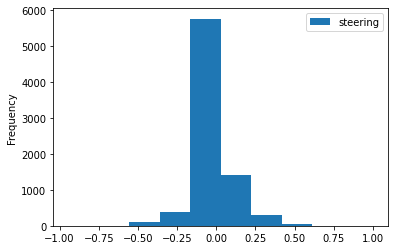

In [12]:
log = pd.read_csv('./data/driving_log.csv')  
log.drop(columns=['throttle','brake','speed'],inplace=True)
log.head()
log.plot.hist()
log = shuffle(log)


In [4]:
def flip(images,labels):
    result_images =[]
    result_measures =[]
    for i,img in enumerate(images):
        flip_image = np.fliplr(img)
        result_images.append(flip_image)
        flip_measure = -labels[i]
        result_measures.append(flip_measure)
    return np.asarray(result_images),np.asarray(result_measures)

def image_generator(logs, batch_size, mode="train"):
    while True:
        start = 0
        end = batch_size
        while start  < len(logs):
            selected = logs[start:end]
            images,labels = batch_loader(selected)
            yield images,labels
            start += batch_size
            end += batch_size

def batch_loader(log_select):
    images = []
    measurements = []
    for l in log_select.itertuples():
        path = './data/'+l.center
        image = cv2.imread(path)
        if image is not None :
            # normal image
            images.append(image)
            measure = l.steering
            measurements.append(measure)
            #Flipped image
            image_flipped = np.fliplr(image)
            measure_flipped = -measure
            images.append(image_flipped)
            measurements.append(measure_flipped)
        else:
            print('Image not read',path)
    return np.asarray(images),np.asarray(measurements)

In [5]:
images,labels = batch_loader(log[1:2])
print(images.shape,labels.shape)
generator = image_generator(log[1:10],10)
images,labels = next(generator)
print(images.shape,labels.shape)

(2, 160, 320, 3) (2,)
(18, 160, 320, 3) (18,)


In [6]:
img_shape = (160, 320, 3)

In [16]:
model = models.Sequential()
model.add(layers.Convolution2D(6,5,5,activation='relu',input_shape=img_shape))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Convolution2D(6,5,5,activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(120))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(84))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [17]:
history = model.fit(image_generator(log,128),
        shuffle=True,
        steps_per_epoch=200,
        epochs=10,
        verbose=1)


Epoch 1/10
200/200 [==============================] - 25s 125ms/step - loss: 56.5366 - accuracy: 0.3638
Epoch 2/10
200/200 [==============================] - 25s 126ms/step - loss: 0.9297 - accuracy: 0.4458
Epoch 3/10
161/200 [=======================>......] - ETA: 4s - loss: 0.4285 - accuracy: 0.4893

KeyboardInterrupt: 

In [9]:
model.save('model.h5')
